In [ ]:
!pip install pandas numpy scikit-learn matplotlib xgboost lightgbm tensorflow openpyxl statsmodels pmdarima prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.7 MB/s eta 0:00:00


In [ ]:
# Cargar BBDD
from google.colab import files
uploaded = files.upload()

Saving ProyectoMBD_MST_ML.xlsx to ProyectoMBD_MST_ML.xlsx


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

# Cargar datos desde el archivo Excel
df = pd.read_excel('ProyectoMBD_MST_ML.xlsx', sheet_name='Sheet1')

# Imprimir columnas
print(df.columns)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Index(['Piscina_Ciclo', 'No_Semana', 'Mes', 'Año', 'Fecha Siembra',
       'Fecha Muestreo', 'Numero_Semanas_Cultivo', 'Epoca', 'Peso Semanal',
       'Incremento semanal', 'TAN', 'Sulfuro de hidrogeno', 'Amoniaco',
       'Alcalinidad', 'Calcio', 'Magnesio', 'Potasio', 'Nitrito', 'Fosfato',
       'Amonio', 'Silicio', 'Oxigeno', 'Temperatura', 'PH', 'Salinidad'],
      dtype='object')


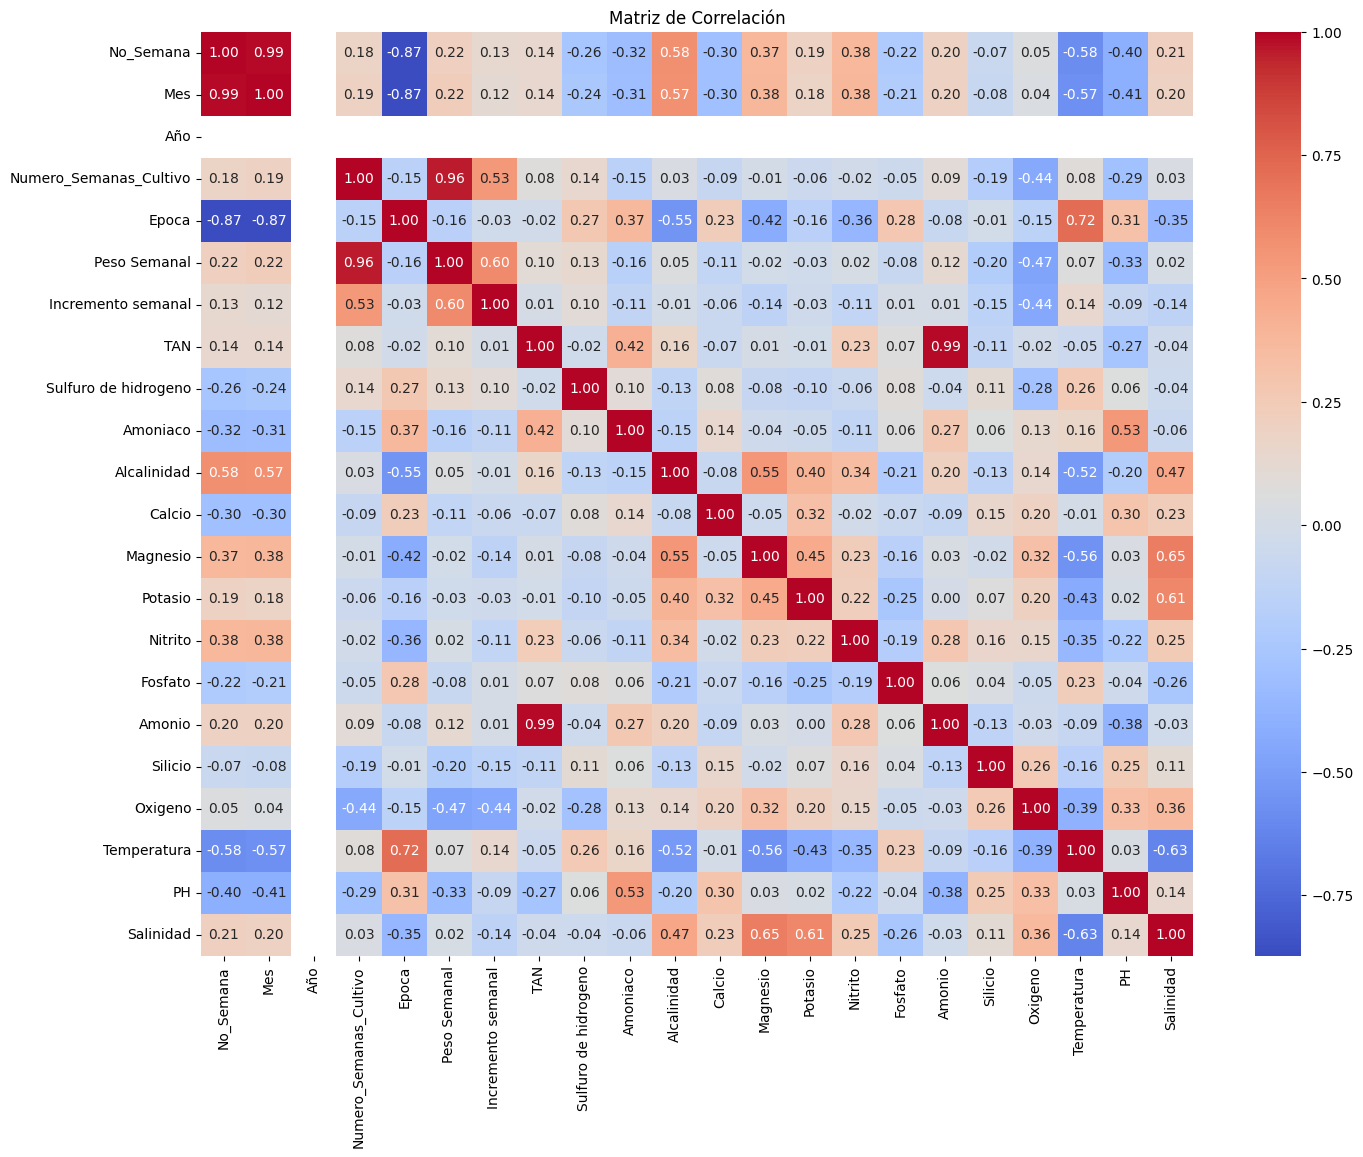

In [ ]:
# Función para identificar y eliminar outliers usando el método IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Cargar datos desde el archivo de Excel (ajusta el nombre del archivo y la hoja si es necesario)
df = pd.read_excel('ProyectoMBD_MST_ML.xlsx', sheet_name='Sheet1')

# Aplicar la función de eliminación de outliers a las columnas relevantes
columns_to_clean = ['Peso Semanal', 'Incremento semanal', 'TAN', 'Sulfuro de hidrogeno', 'Amoniaco',
                    'Alcalinidad', 'Calcio', 'Magnesio', 'Potasio', 'Nitrito', 'Fosfato', 'Amonio',
                    'Silicio', 'Oxigeno', 'Temperatura', 'PH', 'Salinidad']

for column in columns_to_clean:
    df = remove_outliers(df, column)

# Generar la matriz de correlación solo para columnas numéricas
correlation_matrix = df.select_dtypes(include=np.number).corr()
# Visualizar la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
# Generar estadísticas descriptivas para columnas numéricas
df[['Numero_Semanas_Cultivo', 'Incremento semanal', 'Oxigeno', 'Temperatura','Salinidad',  'Sulfuro de hidrogeno', 'Alcalinidad', 'Nitrito', 'Amonio', 'PH']].describe()

,Numero_Semanas_Cultivo,Incremento semanal,Oxigeno,Temperatura,Salinidad,Sulfuro de hidrogeno,Alcalinidad,Nitrito,Amonio,PH
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,5.152582,2.932864,3.586173,28.293192,2.399570,0.041137,156.813380,0.030217,0.129244,8.234538
std,3.069808,1.278031,0.542985,1.723519,0.931615,0.020637,21.920279,0.019995,0.053831,0.239069
min,0.000000,0.200000,2.442857,25.600000,1.000000,0.004000,100.000000,0.003300,0.017585,7.800000
25%,3.000000,2.000000,3.174405,26.925000,1.962500,0.025000,142.000000,0.016500,0.091278,8.070000
50%,5.000000,3.000000,3.557143,27.200000,2.125000,0.039000,157.500000,0.026400,0.121210,8.175000
75%,7.000000,3.800000,3.974107,30.100000,3.000000,0.054000,168.000000,0.042900,0.160410,8.380000
max,16.000000,6.800000,5.200000,31.500000,5.000000,0.096000,219.000000,0.108900,0.300626,8.870000


from matplotlib import pyplot as plt
_df_0['Numero_Semanas_Cultivo'].plot(kind='hist', bins=20, title='Numero_Semanas_Cultivo')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Incremento semanal'].plot(kind='hist', bins=20, title='Incremento semanal')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Oxigeno'].plot(kind='hist', bins=20, title='Oxigeno')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Temperatura'].plot(kind='hist', bins=20, title='Temperatura')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Numero_Semanas_Cultivo', y='Incremento semanal', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Incremento semanal', y='Oxigeno', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Oxigeno', y='Temperatura', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Temperatura', y='Salinidad', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Numero_Semanas_Cultivo'].plot(kind='line', figsize=(8, 4), title='Numero_Semanas_Cultivo')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Incremento semanal'].plot(kind='line', figsize=(8, 4), title='Incremento semanal')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Oxigeno'].plot(kind='line', figsize=(8, 4), title='Oxigeno')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Temperatura'].plot(kind='line', figsize=(8, 4), title='Temperatura')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df['Numero_Semanas_Cultivo'].describe()

,Numero_Semanas_Cultivo
count,426.000000
mean,5.152582
std,3.069808
min,0.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,16.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, 0 to 1010
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Piscina_Ciclo           426 non-null    object        
 1   No_Semana               426 non-null    int64         
 2   Mes                     426 non-null    int64         
 3   Año                     426 non-null    int64         
 4   Fecha Siembra           426 non-null    datetime64[ns]
 5   Fecha Muestreo          426 non-null    datetime64[ns]
 6   Numero_Semanas_Cultivo  426 non-null    int64         
 7   Epoca                   426 non-null    int64         
 8   Peso Semanal            426 non-null    float64       
 9   Incremento semanal      426 non-null    float64       
 10  TAN                     426 non-null    float64       
 11  Sulfuro de hidrogeno    426 non-null    float64       
 12  Amoniaco                426 non-null    float64       

In [ ]:
max_semanas_por_piscina = df.groupby('Piscina_Ciclo')['Numero_Semanas_Cultivo'].max()
print(max_semanas_por_piscina)

Piscina_Ciclo
P2001-5      8
P2001-6     10
P2002-10     6
P2002-9      6
P2003-12     7
            ..
P2047-4      6
P2047-5      2
P2048-3      9
P2048-4     10
P2048-5      5
Name: Numero_Semanas_Cultivo, Length: 91, dtype: int64


Para obtener el número máximo de 'Numero_Semanas_Cultivo' para cada 'Piscina_Ciclo', puedes usar el método groupby() de Pandas junto con max().

**1. df.groupby('Piscina_Ciclo'):** Esto agrupa el DataFrame df por la columna 'Piscina_Ciclo'.

**2. ['Numero_Semanas_Cultivo']:** Selecciona la columna 'Numero_Semanas_Cultivo' dentro de cada grupo.

**3. .max():** Calcula el valor máximo de 'Numero_Semanas_Cultivo' para cada grupo (cada 'Piscina_Ciclo').

**4. print(max_semanas_por_piscina):** Imprime los resultados, mostrando el número máximo de semanas de cultivo para cada 'Piscina_Ciclo'.

In [ ]:
# Obtener el número máximo de semanas de cultivo para cada Piscina_Ciclo
max_semanas_por_piscina = df.groupby('Piscina_Ciclo')['Numero_Semanas_Cultivo'].max()

# Calcular el promedio de los números de semanas máximos
promedio_semanas_maximas = max_semanas_por_piscina.mean()  # Calculate the mean of max_semanas_por_piscina
promedio_semanas_maximas = round(promedio_semanas_maximas) #Redondea al entero más cercano

# Imprimir el resultado
print(f"Promedio de semanas de cultivo máximas: {promedio_semanas_maximas}")

Promedio de semanas de cultivo máximas: 7


In [ ]:
# Obtencion de todos los ciclos de piscinas en la base de datos
unique_piscina_ciclo = df['Piscina_Ciclo'].unique()
print(unique_piscina_ciclo)

['P2001-5' 'P2001-6' 'P2002-10' 'P2002-9' 'P2003-12' 'P2003-14' 'P2004-8'
 'P2004-9' 'P2005-7' 'P2005-9' 'P2006-7' 'P2006-8' 'P2007-8' 'P2007-9'
 'P2008-10' 'P2008-11' 'P2008-9' 'P2009-7' 'P2009-8' 'P2010-6' 'P2010-7'
 'P2010-8' 'P2011-8' 'P2011-9' 'P2012-7' 'P2012-8' 'P2013-6' 'P2013-7'
 'P2013-9' 'P2014-5' 'P2014-6' 'P2014-7' 'P2015-8' 'P2015-9' 'P2016-11'
 'P2016-12' 'P2017-6' 'P2017-7' 'P2017-8' 'P2018-6' 'P2018-7' 'P2020-6'
 'P2020-7' 'P2021-6' 'P2021-7' 'P2021-8' 'P2021-9' 'P2022-10' 'P2022-7'
 'P2022-9' 'P2023-11' 'P2032-4' 'P2032-6' 'P2033-3' 'P2033-5' 'P2033-6'
 'P2034-3' 'P2034-4' 'P2035-6' 'P2036-3' 'P2036-4' 'P2036-5' 'P2036-6'
 'P2037-3' 'P2037-4' 'P2038-3' 'P2038-4' 'P2039-3' 'P2039-4' 'P2040-10'
 'P2040-7' 'P2040-8' 'P2041-3' 'P2041-4' 'P2042-3' 'P2042-5' 'P2043-3'
 'P2043-4' 'P2044-3' 'P2044-4' 'P2044-5' 'P2045-5' 'P2045-6' 'P2046-3'
 'P2046-4' 'P2047-3' 'P2047-4' 'P2047-5' 'P2048-3' 'P2048-4' 'P2048-5']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

MSE: 8.547810072252856
RMSE: 2.923663809717673
MAE: 2.1119639830399675
R²: -0.41879634396000265


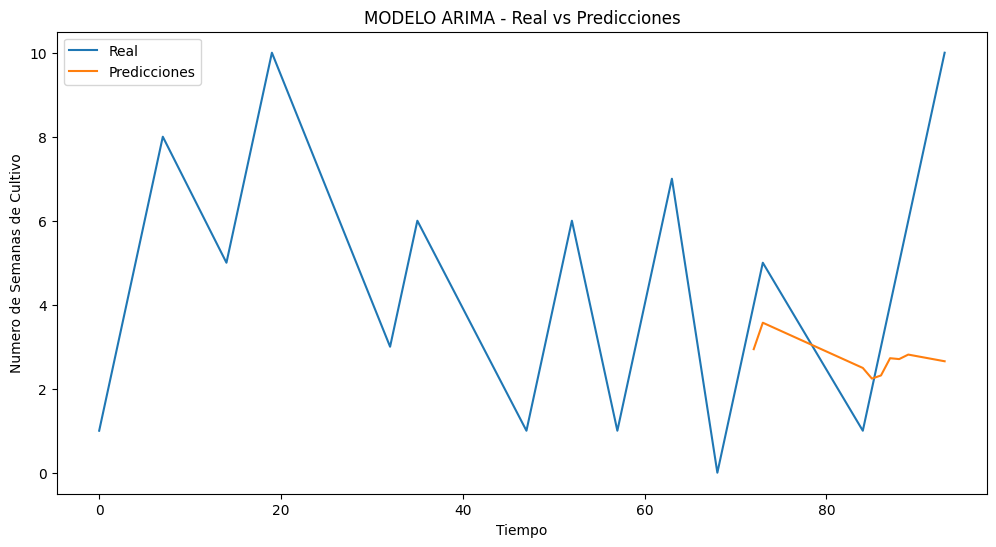

In [ ]:
###################### MODELO DE SERIES DE TIEMPO ARIMA ######################

# 1. Seleccionar un grupo específico de 'Piscina_Ciclo'
# Corrected: Define grupo_piscina as a list of strings
grupo_piscina = ['P2001-5', 'P2001-6', 'P2002-10', 'P2002-9', 'P2003-12', 'P2003-14', 'P2004-8']
df_grupo = df[df['Piscina_Ciclo'].isin(grupo_piscina)]

# 2. Crear la serie temporal a partir de 'Numero_Semanas_Cultivo' del grupo seleccionado
time_series_data = df_grupo['Numero_Semanas_Cultivo']

# 3. Dividir en conjuntos de entrenamiento y prueba (80% train, 20% test)
train_data, test_data = train_test_split(time_series_data, test_size=0.2, shuffle=False)

# 4. Ajustar el modelo ARIMA al conjunto de entrenamiento
# Define el orden (p, d, q) del modelo ARIMA
model = ARIMA(train_data, order=(5, 1, 0))  # Ajusta el orden según sea necesario
model_fit = model.fit()

# 5. Hacer predicciones en el conjunto de prueba
predictions = model_fit.predict(start=len(train_data), end=len(time_series_data)-1)

# 6. Evaluar el modelo usando MSE, RMSE, MAE, R²
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)  # or mean_squared_error(test_data, predictions, squared=False)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# 7. (Opcional) Graficar los resultados
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.plot(time_series_data.index, time_series_data.values, label='Real')  # Plot original data with index
plt.plot(test_data.index, predictions, label='Predicciones')  # Plot predictions with test data index
plt.legend()
plt.title('MODELO ARIMA - Real vs Predicciones')  # Add a title
plt.xlabel('Tiempo')  # Add x-axis label
plt.ylabel('Numero de Semanas de Cultivo')  # Add y-axis label
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec


SARIMA Model Evaluation:
MSE: 21.918771571878292
RMSE: 4.681748772828193
MAE: 3.3989422238547653
R²: -2.638156756807667


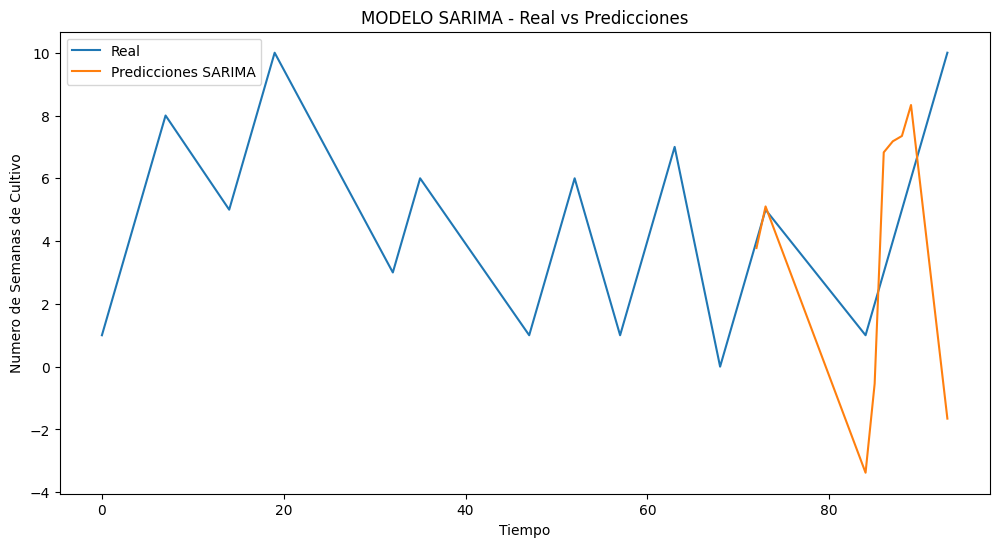

In [ ]:
###################### MODELOS DE SERIES DE TIEMPO SARIMA ######################

# 1. Seleccionar un grupo específico de 'Piscina_Ciclo'
# Corrected: Define grupo_piscina as a list of strings
grupo_piscina = ['P2001-5', 'P2001-6', 'P2002-10', 'P2002-9', 'P2003-12', 'P2003-14', 'P2004-8']
df_grupo = df[df['Piscina_Ciclo'].isin(grupo_piscina)]

# 2. Crear la serie temporal (same as ARIMA)
time_series_data_sarima = df_grupo['Numero_Semanas_Cultivo']

# 3. Dividir en conjuntos de entrenamiento y prueba (same as ARIMA)
train_data_sarima, test_data_sarima = train_test_split(time_series_data_sarima, test_size=0.2, shuffle=False)

# 4. Ajustar el modelo SARIMA al conjunto de entrenamiento
# Define the order (p, d, q) and seasonal order (P, D, Q, s)
model_sarima = SARIMAX(train_data_sarima, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12)) # Adjust orders as needed
model_fit_sarima = model_sarima.fit()

# 5. Hacer predicciones en el conjunto de prueba
predictions_sarima = model_fit_sarima.predict(start=len(train_data_sarima), end=len(time_series_data_sarima)-1)

# 6. Evaluar el modelo usando MSE, RMSE, MAE, R²
mse_sarima = mean_squared_error(test_data_sarima, predictions_sarima)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(test_data_sarima, predictions_sarima)
r2_sarima = r2_score(test_data_sarima, predictions_sarima)

print("\nSARIMA Model Evaluation:")
print(f"MSE: {mse_sarima}")
print(f"RMSE: {rmse_sarima}")
print(f"MAE: {mae_sarima}")
print(f"R²: {r2_sarima}")

# 7. (Opcional) Graficar los resultados
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.plot(time_series_data_sarima.index, time_series_data_sarima.values, label='Real')
plt.plot(test_data_sarima.index, predictions_sarima, label='Predicciones SARIMA')
plt.legend()
plt.title('MODELO SARIMA - Real vs Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Numero de Semanas de Cultivo')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



ETS Model Evaluation:
MSE: 13.925934091840864
RMSE: 3.731746788280371
MAE: 2.5925935789220236
R²: -1.3114767652440773


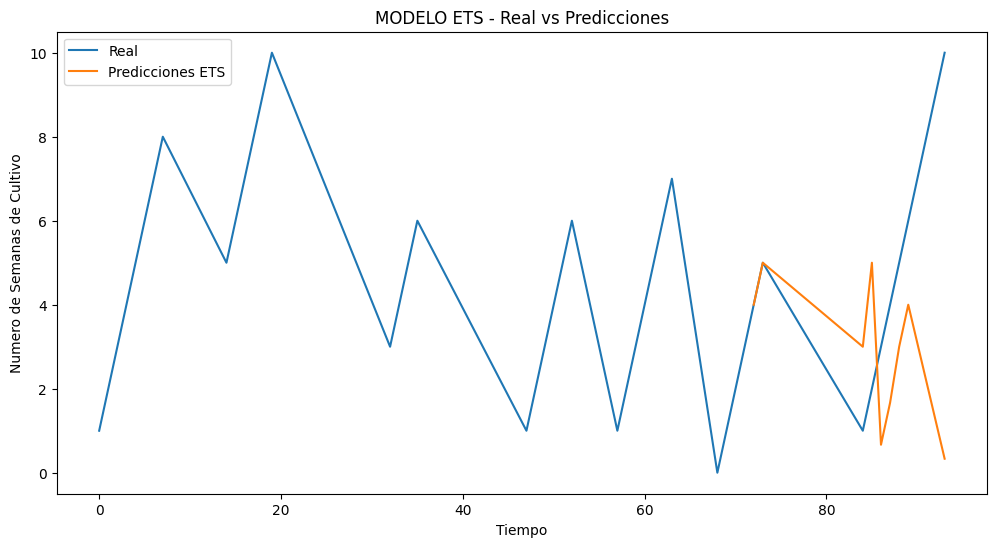

In [ ]:
###################### MODELO DE SERIES DE TIEMPO ETS ######################

# 1. Seleccionar un grupo específico de 'Piscina_Ciclo'
# Corrected: Define grupo_piscina as a list of strings
grupo_piscina = ['P2001-5', 'P2001-6', 'P2002-10', 'P2002-9', 'P2003-12', 'P2003-14', 'P2004-8']
df_grupo = df[df['Piscina_Ciclo'].isin(grupo_piscina)]

# 2. Crear la serie temporal (same as ARIMA/SARIMA)
time_series_data_ets = df_grupo['Numero_Semanas_Cultivo']

# 3. Dividir en conjuntos de entrenamiento y prueba (same as ARIMA/SARIMA)
train_data_ets, test_data_ets = train_test_split(time_series_data_ets, test_size=0.2, shuffle=False)

# 4. Ajustar el modelo ETS al conjunto de entrenamiento
# Define the model type (e.g., 'add', 'mul', 'additive', 'multiplicative') and trend/seasonal components
# You might need to experiment with different model types and components based on your data
model_ets = ExponentialSmoothing(train_data_ets, trend='add', seasonal='add', seasonal_periods=12)  # Adjust parameters as needed
model_fit_ets = model_ets.fit()

# 5. Hacer predicciones en el conjunto de prueba
predictions_ets = model_fit_ets.predict(start=len(train_data_ets), end=len(time_series_data_ets)-1)

# 6. Evaluar el modelo usando MSE, RMSE, MAE, R²
mse_ets = mean_squared_error(test_data_ets, predictions_ets)
rmse_ets = np.sqrt(mse_ets)
mae_ets = mean_absolute_error(test_data_ets, predictions_ets)
r2_ets = r2_score(test_data_ets, predictions_ets)

print("\nETS Model Evaluation:")
print(f"MSE: {mse_ets}")
print(f"RMSE: {rmse_ets}")
print(f"MAE: {mae_ets}")
print(f"R²: {r2_ets}")

# 7. (Opcional) Graficar los resultados
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.plot(time_series_data_ets.index, time_series_data_ets.values, label='Real')
plt.plot(test_data_ets.index, predictions_ets, label='Predicciones ETS')
plt.legend()
plt.title('MODELO ETS - Real vs Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Numero de Semanas de Cultivo')
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygegg3eb/86q5axs1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygegg3eb/8rect5qo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35120', 'data', 'file=/tmp/tmpygegg3eb/86q5axs1.json', 'init=/tmp/tmpygegg3eb/8rect5qo.json', 'output', 'file=/tmp/tmpygegg3eb/prophet_modelvp7ahdl4/prophet_model-20241116194919.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:49:20 - cmdstanpy - INFO - Chain [1] start processing
I


Prophet Model Evaluation:
MSE: 6.517675156940029
RMSE: 2.5529737869668834
MAE: 1.9841519851929494
R²: -0.08182722891832439


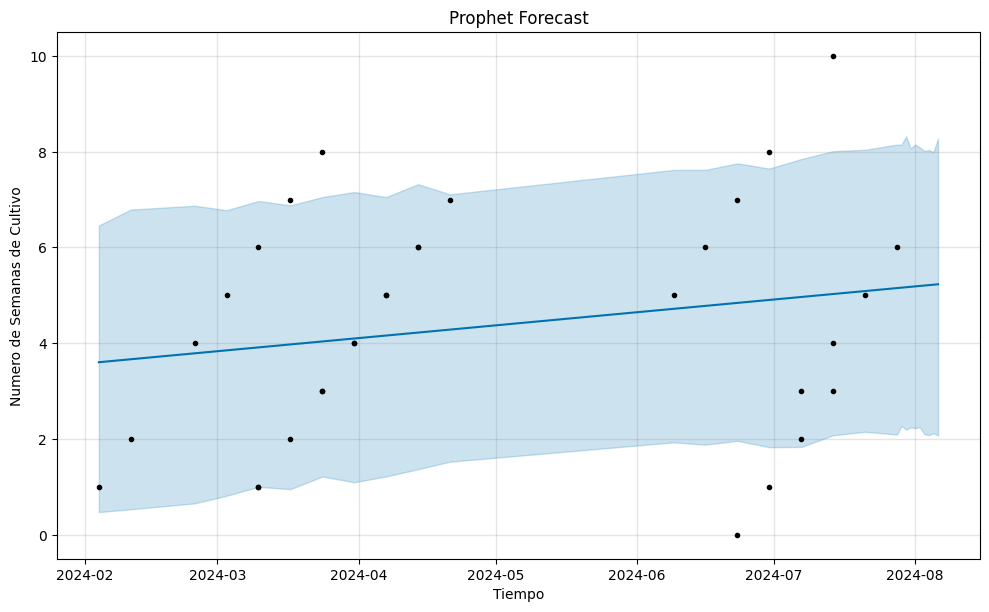

In [ ]:
###################### MODELO DE SERIES DE TIEMPO PROPHET ######################

# 1. Seleccionar un grupo específico de 'Piscina_Ciclo'
# Corrected: Define grupo_piscina as a list of strings
grupo_piscina = ['P2001-5', 'P2001-6', 'P2002-10', 'P2002-9', 'P2003-12', 'P2003-14', 'P2004-8']
df_grupo = df[df['Piscina_Ciclo'].isin(grupo_piscina)]

# 2. Preparar los datos para Prophet
# Prophet requires a DataFrame with columns 'ds' (datestamp) and 'y' (values)
df_prophet = df_grupo[['Fecha Muestreo', 'Numero_Semanas_Cultivo']].copy()
df_prophet.rename(columns={'Fecha Muestreo': 'ds', 'Numero_Semanas_Cultivo': 'y'}, inplace=True)

# 3. Dividir en conjuntos de entrenamiento y prueba
train_data_prophet = df_prophet[:int(len(df_prophet) * 0.8)]  # 80% for training
test_data_prophet = df_prophet[int(len(df_prophet) * 0.8):]  # 20% for testing

# 4. Ajustar el modelo Prophet al conjunto de entrenamiento
model_prophet = Prophet()
model_prophet.fit(train_data_prophet)

# 5. Hacer predicciones en el conjunto de prueba
future = model_prophet.make_future_dataframe(periods=len(test_data_prophet), freq='D')  # Adjust freq if needed
predictions_prophet = model_prophet.predict(future)

# 6. Evaluar el modelo usando MSE, RMSE, MAE, R²
# Extract predictions for the test set period
predictions_prophet_test = predictions_prophet['yhat'][-len(test_data_prophet):]

mse_prophet = mean_squared_error(test_data_prophet['y'], predictions_prophet_test)
rmse_prophet = np.sqrt(mse_prophet)
mae_prophet = mean_absolute_error(test_data_prophet['y'], predictions_prophet_test)
r2_prophet = r2_score(test_data_prophet['y'], predictions_prophet_test)

print("\nProphet Model Evaluation:")
print(f"MSE: {mse_prophet}")
print(f"RMSE: {rmse_prophet}")
print(f"MAE: {mae_prophet}")
print(f"R²: {r2_prophet}")

# 7. (Opcional) Graficar los resultados
model_prophet.plot(predictions_prophet)
plt.title('Prophet Forecast')
plt.xlabel('Tiempo')
plt.ylabel('Numero de Semanas de Cultivo')
plt.show()

In [ ]:
# Agrupación en una matriz de resultados de los modelos por metricas en donde se resalte el mejor resultado

results = {
    'Model': ['ARIMA', 'SARIMA', 'ETS', 'Prophet'],
    'MSE': [mse, mse_sarima, mse_ets, mse_prophet],
    'RMSE': [rmse, rmse_sarima, rmse_ets, rmse_prophet],
    'MAE': [mae, mae_sarima, mae_ets, mae_prophet],
    'R²': [r2, r2_sarima, r2_ets, r2_prophet]
}

results_df = pd.DataFrame(results)

def highlight_best(s):
    """Highlight the maximum value in a Series yellow."""
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):  # New function to highlight minimum (for MSE, RMSE, MAE)
    """Highlight the minimum value in a Series lightgreen."""
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

# Apply the functions to highlight best/minimum values for each metric
styled_results_df = results_df.style.apply(highlight_min, subset=['MSE', 'RMSE', 'MAE']) \
                                   .apply(highlight_best, subset=['R²'])

# Display the styled DataFrame
display(styled_results_df)

,Model,MSE,RMSE,MAE,R²
0,ARIMA,8.547810,2.923664,2.111964,-0.418796
1,SARIMA,21.918772,4.681749,3.398942,-2.638157
2,ETS,13.925934,3.731747,2.592594,-1.311477
3,Prophet,6.517675,2.552974,1.984152,-0.081827


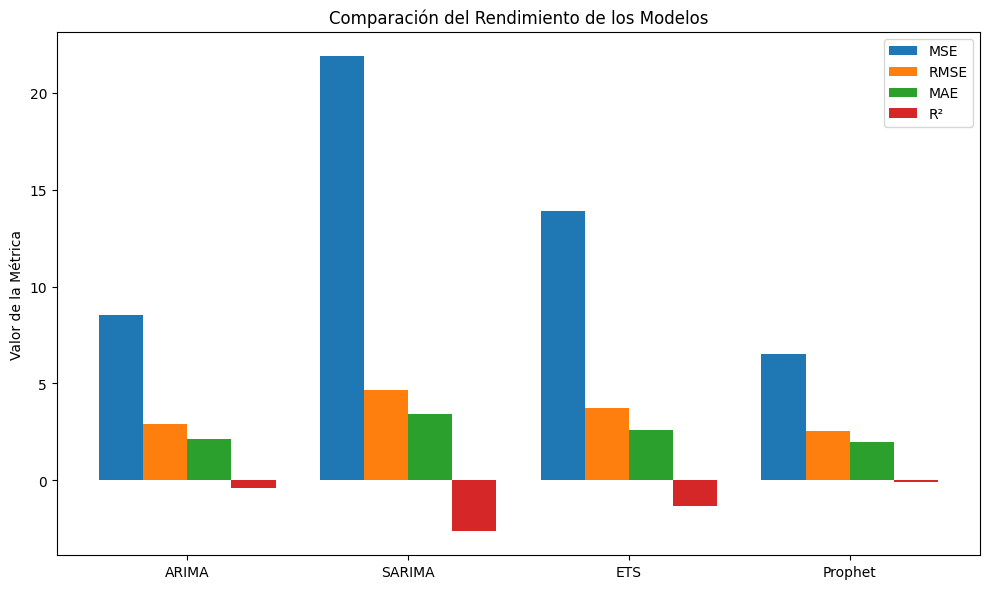

In [ ]:
############## ANÁLISIS DE RESULTADOS DE MODELOS SEGUN MÉTRICAS ##############
# Almacenar los resultados de la evaluación en un DataFrame
results_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'ETS', 'Prophet'],
    'MSE': [mse, mse_sarima, mse_ets, mse_prophet],
    'RMSE': [rmse, rmse_sarima, rmse_ets, rmse_prophet],
    'MAE': [mae, mae_sarima, mae_ets, mae_prophet],
    'R²': [r2, r2_sarima, r2_ets, r2_prophet]
})

# Creamos un gráfico de barras para visualizar los resultados
fig, ax = plt.subplots(figsize=(10, 6))

# Definimos las posiciones de las barras en el eje x
x_pos = np.arange(len(results_df['Model']))

# Creamos las barras para MSE, RMSE, MAE, y R²
ancho_barra = 0.2  # Ajustamos el ancho de las barras para acomodar 4 métricas
ax.bar(x_pos - 1.5 * ancho_barra, results_df['MSE'], width=ancho_barra, label='MSE') # Agregamos la barra para MSE
ax.bar(x_pos - 0.5 * ancho_barra, results_df['RMSE'], width=ancho_barra, label='RMSE')
ax.bar(x_pos + 0.5 * ancho_barra, results_df['MAE'], width=ancho_barra, label='MAE')
ax.bar(x_pos + 1.5 * ancho_barra, results_df['R²'], width=ancho_barra, label='R²')

# Configuramos las etiquetas y marcas del eje x
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Model'])

# Configuramos la etiqueta del eje y y el título del gráfico
ax.set_ylabel('Valor de la Métrica')
ax.set_title('Comparación del Rendimiento de los Modelos')

# Agregamos una leyenda
ax.legend()

# Mostramos el gráfico
plt.tight_layout()
plt.show()

In [ ]:
############### SELECCIÓN DEL MEJOR MODELO ###############
# Seleccionar el mejor modelo basado en RMSE (puedes cambiar la métrica si lo deseas)
best_model = results_df.loc[results_df['RMSE'].idxmin()]['Model']
print(f"El mejor modelo es: {best_model}")

El mejor modelo es: Prophet


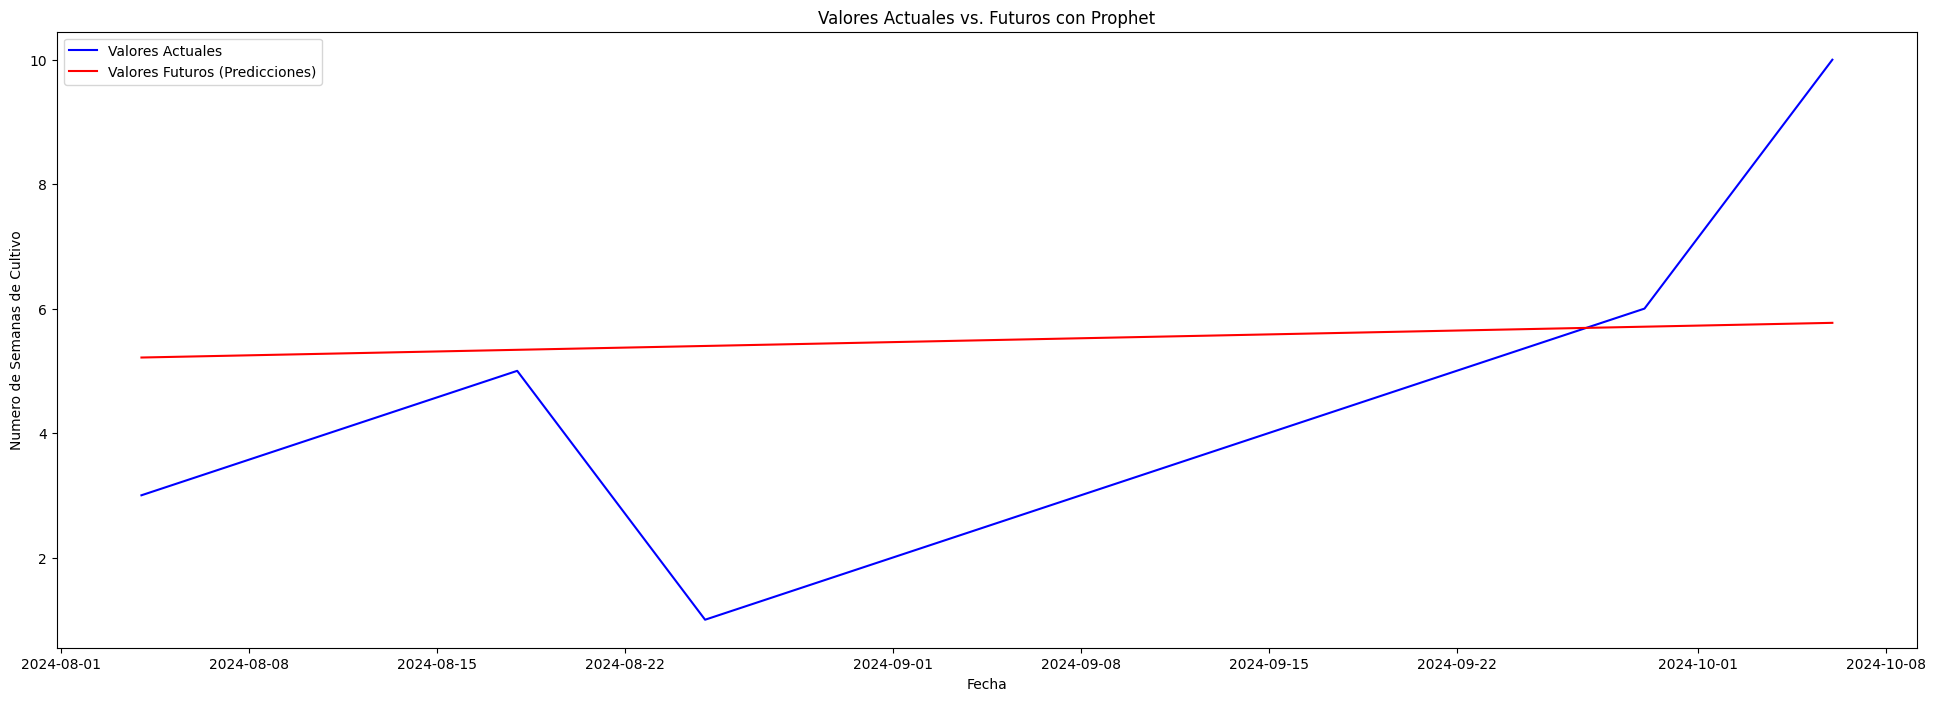

In [ ]:
# Obtener los últimos 'num_futuro' valores reales (actuales)
actual_values = df_prophet['y'][-num_futuro:]

# Crear un DataFrame para la gráfica
plot_df = pd.DataFrame({
    'ds': future_predictions['ds'],  # Fechas futuras
    'Actual': actual_values.values,  # Valores actuales
    'Predicciones': future_predictions['yhat'].values  # Predicciones futuras
})

# Graficar los valores actuales vs. futuros
plt.figure(figsize=(24, 8))
plt.plot(plot_df['ds'], plot_df['Actual'], label='Valores Actuales', color='blue')
plt.plot(plot_df['ds'], plot_df['Predicciones'], label='Valores Futuros (Predicciones)', color='red')
plt.legend()
plt.title('Valores Actuales vs. Futuros con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Numero de Semanas de Cultivo')
plt.show()